# 1. 题目解读
你作为新兴数据的探索者和可视化设计者，被家乡一家小型游乐园管理员的要求回答几个关于其游乐园运营相关的问题。为了进行需求分析，他们向你提供了一个数据库，其中包含游乐园一天运营相关的信息其中数据，如下：
1. checkins 登记 :
- 描述：游乐园当天所有游客的登记数据。该数据包括两类登记数据: 推测登记数据和实际登
记数据。
- 字段：visitorID, timestamp, attraction, duration, type。

2. attractions 景点:
- 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括VAST 挑战地图，如过山
车场区 (Coaster Alley)、 冻原之地 (Tundra Land) 等等。类别包括惊险飞车 (Thrill Rides)、儿童碰碰车
(Kiddie Rides) 等。类型包括户外过山车 (Outdoor Coaster)、其他游乐项目 (Other Ride) 、旋转木马
(Carussel) 等等。
- 字段：attractionID, name, region, category, type

3. sequences 序列 :
- 游客登记序列。这些序列显示每五分钟进入游乐场的游客位置。如果游客尚未进入游乐场，则
该时间段内序列的值为 0 。如果游客在游乐场中，则序列显示游客时间上最近登记的景点，直到该遊
客登记其他景点，或离开游乐场。
- 字段：visitorID, sequence


1：游乐园管理员对数据窗口中游乐项目“Atmosfear”的参入量表示担心。为了减轻他们的压力，他们要求你创建一个此游乐项目总参入量的控制图。使用提供的数据，创建一个控制图，以显示参入量、平均值以及一到两个标准差的标准差带。

2：游乐园的一些管理员在解释“Atmosfear”参入量的控制图时遇到困难，因此他们要求你除了提供在上一个问题中创建的控制图外，还要提供参入量的移动平均图。在此情况下，他们要求你针对移动平均窗口的大小使用 50 个样本。

3：为了提供有关图表的选项，游乐园管理员还要求你提供一个包含 50 个样本的移动平均窗口，其中通过相同的“Atmosfear”参入量数据使用指数加权（即指数加权移动平均值）计算平均值。

管理注意事项

为了让你的答案可以正确登记在该系统中，你必须将你的答案代码填写在每个问题对应的单元格内。此外，你的作业必须连同该单元格区域显示的代码一同提交。该显示区域应该仅仅包含你为该问题给出的答案，除此之外别无其它信息，要么就是没有正确选择答案。待评分的每个单元格在开头有几行评语。这些行极其重要，不得修改或删除。

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
#正常显示中文
plt.rcParams["font.sans-serif"]=["SimHei"]

In [2]:
db_filename = 'dinofunworld.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# 2. 检查各个表格
简单打印数据表中的内容，并通过pandas.DataFrame.describe()了解数据类型以及特点。

In [3]:
# 获取表名
c.execute("select name from sqlite_master where type='table'")
tab_name=c.fetchall()
tab_name=[line[0] for line in tab_name]
tab_name

['checkin', 'attraction', 'sequences']

In [4]:
#获取表的列名（字段名），保存在col_names列表,每个表的字段名集为一个列表
col_names=[]
for line in tab_name:
    c.execute('pragma table_info({})'.format(line))
    col_name=c.fetchall()
    col_name=[x[1] for x in col_name]
    col_names.append(col_name)
    col_name=tuple(col_name)
col_names

[['index', 'visitorID', 'timestamp', 'attraction', 'duration', 'type'],
 ['index', 'AttractionID', 'Name', 'Region', 'Category', 'type'],
 ['index', 'visitorID', 'sequence']]

In [5]:
# 检查表 checkin
sql = "SELECT visitorID, timestamp, attraction, duration, type FROM checkin"
df1 = pd.read_sql(sql, conn)
print(len(df1))
print(df1.describe())
print(df1.head())

506242
          visitorID     attraction
count  5.062420e+05  506242.000000
mean   1.052300e+06      32.212315
std    6.039318e+05      25.189779
min    4.360000e+02       1.000000
25%    5.375750e+05       8.000000
50%    1.051814e+06      30.000000
75%    1.574806e+06      48.000000
max    2.096715e+06      85.000000
   visitorID            timestamp  attraction duration      type
0        436  2014-06-08 09:48:51          83  0:00:59    actual
1        436  2014-06-08 09:56:46          42  0:08:03  inferred
2        436  2014-06-08 10:14:04           6  0:06:16    actual
3        436  2014-06-08 10:29:38           5  1:07:41    actual
4        436  2014-06-08 11:38:55          49  0:08:43  inferred


In [6]:
# 检查表 attraction
sql = "SELECT attractionId, name, region, category, type FROM attraction"
df2 = pd.read_sql(sql, conn)
print(len(df2))
print(df2.describe())
print(df2.head())

71
       AttractionID
count     71.000000
mean      36.774648
std       22.110888
min        1.000000
25%       18.500000
50%       36.000000
75%       53.500000
max       85.000000
   AttractionID                    Name         Region        Category  \
0             1  Wrightiraptor Mountain  Coaster Alley  Thrill Rides\r   
1             2      Galactosaurus Rage  Coaster Alley  Thrill Rides\r   
2             3      Auvilotops Express    Tundra Land  Thrill Rides\r   
3             4              TerrorSaur       Wet Land  Thrill Rides\r   
4             5       Wendisaurus Chase    Tundra Land  Thrill Rides\r   

              type  
0  Outdoor Coaster  
1  Outdoor Coaster  
2  Outdoor Coaster  
3       Other Ride  
4  Outdoor Coaster  


In [7]:
# 检查表 sequences
sql = "SELECT visitorID, sequence FROM sequences"
df3 = pd.read_sql(sql, conn)
print(len(df3))
print(df3.describe())
print(df3.head())

11374
          visitorID
count  1.137400e+04
mean   1.054370e+06
std    6.048169e+05
min    4.360000e+02
25%    5.355695e+05
50%    1.053090e+06
75%    1.580030e+06
max    2.096715e+06
   visitorID                                           sequence
0        436  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
1        878  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
2        941  0-0-0-0-0-0-0-0-0-0-84-0-1-1-24-24-24-8-1-0-3-...
3       1197  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
4       1217  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...


# 2. Atmosfear参入量图
使用checkin表和attraction表。找到折线图所需要的访问量：

1. 定位attraction中字段为Name中Atmosfear的景点名称和对应ID。
2. 在checking表中找到对应景点ID的一天内每6分钟统计一次出现次数。
3. 定位日内时间为x轴。
4. 作图。

In [17]:
# 转换duration时间为分钟
def transTimeToHour(a_duration):
    if a_duration is None:
        return None
    elif '@'in a_duration:
        return None
    sep_list = a_duration[:].split(':')  # 字符串切分
    hour = 0
    hour += int(sep_list[0])   # 小时
    hour += int(sep_list[1]) / 60  # 分钟转小时
    hour += int(sep_list[2]) / 60 / 60  # 秒转小时
    return round(hour, 1)  # 每0.1小时则为每6分钟

# 表拼接
tmp_q2_df = pd.merge(left=df1, right=df2, how='left', left_on='attraction', right_on='AttractionID')
# 确定Name 为 Atmosfear
tmp_q2_df = tmp_q2_df[tmp_q2_df['Name'] == 'Atmosfear']
# 重新处理时间
tmp_q2_df['new_time'] = tmp_q2_df['timestamp'].apply(lambda x: transTimeToHour(x[-8:]))
# 只看new_time并groupby
tmp_q2_result = tmp_q2_df.groupby('new_time').count()['attraction']
tmp_q2_result

new_time
8.1       7
8.2      62
8.3     113
8.4     103
8.5     108
       ... 
22.6     38
22.7      3
22.8      3
23.0      4
23.1      5
Name: attraction, Length: 150, dtype: int64

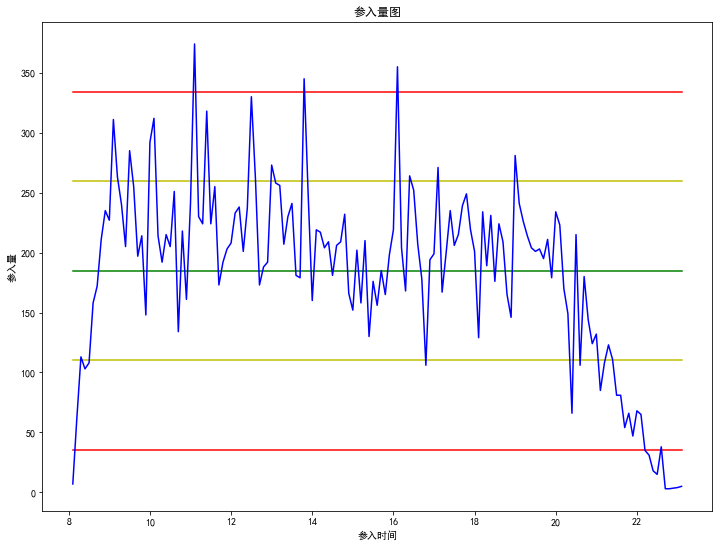

In [53]:
# 作图
xax = list(tmp_q2_result.index)
data = np.array(tmp_q2_result.values)
mean = np.nanmean(data)
std = np.nanstd(data)

plt.figure(figsize=(12,9))
plt.plot([xax[0], xax[-1]], [mean, mean], 'g-')
plt.plot([xax[0], xax[-1]], [mean + std, mean + std], 'y-')
plt.plot([xax[0], xax[-1]], [mean - std, mean - std], 'y-')
plt.plot([xax[0], xax[-1]], [mean + 2*std, mean + 2*std], 'r-')
plt.plot([xax[0], xax[-1]], [mean - 2*std, mean - 2*std], 'r-')
plt.plot(xax, data, 'b-')
plt.xlabel('参入时间')
plt.ylabel('参入量')
plt.title('参入量图')
plt.show()

可以从图上看出，其参入量随着时间的变化有不同成都的波动，在白天时，逐渐上升，中午休息时间相对参入量较少，下午继续升高，直至关门前逐渐减少。

# 3. 移动平均图
使用上述数据，进行移动平均图作图。

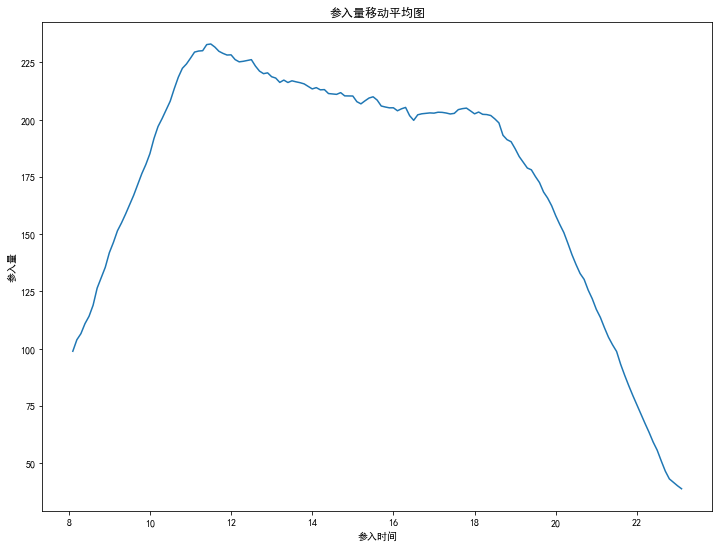

In [54]:
window_size = 50
plt.figure(figsize=(12,9))
plt.plot(xax, np.convolve(data, np.ones(window_size,)/window_size, 'same'))
plt.xlabel('参入时间')
plt.ylabel('参入量')
plt.title('参入量移动平均图')
plt.show()

移动平均图可以更明显的表现出趋势，一天的开始逐渐上升，白天整天随着时间的推移虽然参入量略有下降，但总体参入量相对平稳，直至晚上开始逐渐下降。

# 4. 指数加权图
使用上述数据作指数加权图。

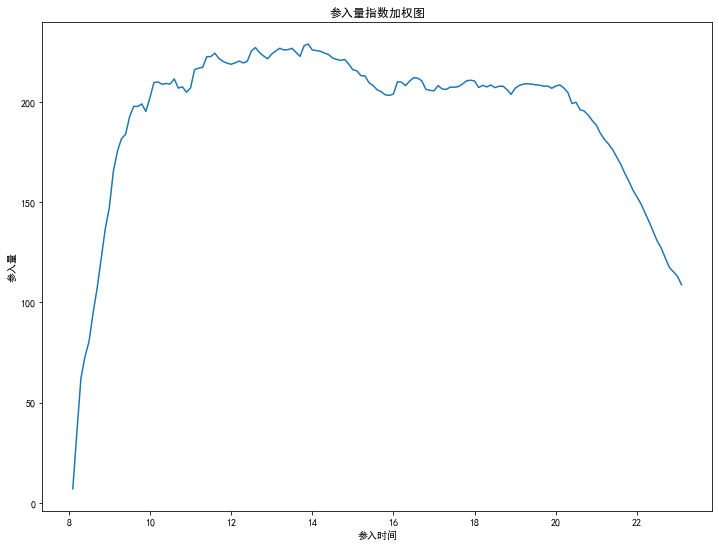

In [57]:
span = 50
df = pd.DataFrame({'data':data})
df_exp = df.ewm(span=50).mean()
plt.figure(figsize=(12,9))
plt.plot(xax, df_exp)
plt.xlabel('参入时间')
plt.ylabel('参入量')
plt.title('参入量指数加权图')
plt.show()

类似的，一天的开始逐渐上升，白天整天随着时间的推移虽然参入量略有下降，但总体参入量相对平稳，直至晚上开始逐渐下降。但相较于移动平均图，指数加权图更平稳一些。